In [1]:
import sys
import numpy as np
import import_ipynb
import pandas as pd
from pathlib import Path
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_processing import matrices_assembly as assembly, gaussian_quadrature
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 3: Problem 3 (p33)
# Computation Domain, $\Omega_c$, for 3-noded Linear Triangular Elements, $P_1$

## Physics Constants

In [2]:
OMEGA = 2 * np.pi * 3E8
K0 = OMEGA * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Omega: {OMEGA:.3e} rad/s')
print(f'Wavelength: {WAVELENGTH:.4} m')
print(f'K0^2: {K0**2:.6} 1/m')

Omega: 1.885e+09 rad/s
Wavelength: 0.9993 m
K0^2: 39.5331 1/m


In [3]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'},
            {'tag': 102, 'type': 'inn_pml', 'value': None, 'name': 'inner_truncated_domain'},
            {'tag': 103, 'type': 'out_pml', 'value': None, 'name': 'outer_truncated_domain'}]

MATERIAL = [{'tag': 201, 'name': 'omega_pml',
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
             {'tag': 202, 'name': 'omega_fs',
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

OMEGA_KEY = 'a'

# Criar geometria coaxial
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, OMEGA_KEY, n=1, view_mesh=False)

Malha salva em pre_processing/mesh/rectangular_pml_domain_Triangle1.msh
Model rectangular_pml (2D)
Info     : 20 geometric entities
Info     : 5 Physical Groups
Info     : 4072 nodes in total
Info     : 7841 2-D elements in total


## Boundary Conditions

In [4]:
nodes_data = mesh_data['nodes']
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}
dirichlet_nodes

{5: {'xg': (0.49965409666667754, 0.0),
  'bc': {'tag': 101,
   'type': 'Dirichlet',
   'value': (-1-1.2246467991473532e-16j)}},
 166: {'xg': (0.4971712032207434, 0.04974948244787898),
  'bc': {'tag': 101,
   'type': 'Dirichlet',
   'value': (-0.9998781464493253-0.015610645504324306j)}},
 167: {'xg': (0.48974719899349417, 0.09900453218828091),
  'bc': {'tag': 101,
   'type': 'Dirichlet',
   'value': (-0.9980606072342973-0.062249693068365086j)}},
 168: {'xg': (0.47745586707431675, 0.147275630408109),
  'bc': {'tag': 101,
   'type': 'Dirichlet',
   'value': (-0.9902756095227782-0.13911943496251752j)}},
 169: {'xg': (0.4604193642419407, 0.19408303724653705),
  'bc': {'tag': 101,
   'type': 'Dirichlet',
   'value': (-0.9697260791778134-0.24419527301408855j)}},
 170: {'xg': (0.43880700691549007, 0.23896155966527874),
  'bc': {'tag': 101,
   'type': 'Dirichlet',
   'value': (-0.9277052391059711-0.37331352685823327j)}},
 171: {'xg': (0.41283358841184165, 0.28146517474599886),
  'bc': {'tag': 1

In [5]:
cell = mesh_data['cell'][1]; cell

{'conn': [820, 1717, 821],
 'conn_sorted': [820, 821, 1717],
 'conn_edge': [464, 465, 466],
 'material': {'tag': 201,
  'name': 'omega_pml',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1},
 'stiffness_term': [array([[1.        -0.32370393j, 0.        +0.j        ],
         [0.        +0.j        , 0.90515412+0.29300194j]]),
  array([[1.        -0.32128696j, 0.        +0.j        ],
         [0.        +0.j        , 0.90643316+0.29122515j]]),
  array([[1.        -0.34183886j, 0.        +0.j        ],
         [0.        +0.j        , 0.89537234+0.30607306j]]),
  array([[1.        -0.30798596j, 0.        +0.j        ],
         [0.        +0.j        , 0.91336266+0.28130288j]]),
  array([[1.        -0.32780344j, 0.        +0.j        ],
         [0.        +0.j        , 0.90297115+0.29599705j]]),
  array([[1.        -0.29294454j, 0.        +0.j        ],
         [0.        +0.j        , 0.92096593+0.26979194j]]),
  array([[1.        -0.3503638j , 0.      

In [6]:
ma = cell['stiffness_term']
graph.matrix2table(ma, 'Stiffness matrix')

,Entry 1,Entry 2,Entry 3,Entry 4
Matrix 1,1.000e+00-3.237e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,9.052e-01+2.930e-01j
Matrix 2,1.000e+00-3.213e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,9.064e-01+2.912e-01j
Matrix 3,1.000e+00-3.418e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,8.954e-01+3.061e-01j
Matrix 4,1.000e+00-3.080e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,9.134e-01+2.813e-01j
Matrix 5,1.000e+00-3.278e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,9.030e-01+2.960e-01j
Matrix 6,1.000e+00-2.929e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,9.210e-01+2.698e-01j
Matrix 7,1.000e+00-3.504e-01j,0.000e+00+0.000e+00j,0.000e+00+0.000e+00j,8.907e-01+3.121e-01j


In [7]:
ai = [nodes_data[idx]['xg'] for idx in cell['conn']]
gauss_points, _ = gaussian_quadrature.gauss_data(FINITE_ELEMENT)
for xik in gauss_points: 
    xg_e, yg_e = assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, ai, xik)
    print(f'xik: {xik}, xg_e: {xg_e}, yg_e: {yg_e}')

xik: (0.33333333, 0.33333333), xg_e: -0.024297509420511103, yg_e: -1.2201351853976574
xik: (0.47014206, 0.47014206), xg_e: -0.03593944495779218, yg_e: -1.2184863591375352
xik: (0.05971587, 0.47014206), xg_e: -0.018913168504213543, yg_e: -1.2325066201799124
xik: (0.47014206, 0.05971587), xg_e: -0.018039914799527587, yg_e: -1.2094125768755253
xik: (0.10128651, 0.10128651), xg_e: -0.00455115171314064, yg_e: -1.2229318263020348
xik: (0.79742699, 0.10128651), xg_e: -0.03343010864083311, yg_e: -1.199151493834056
xik: (0.10128651, 0.79742699), xg_e: -0.03491126960948831, yg_e: -1.2383222358158408


## `pml_attributes()`

In [8]:
# Lados do domínio retangular interno
OMEGA_DOMAIN = {'a': {'h': WAVELENGTH/10, 'L': WAVELENGTH/2, 'ra': WAVELENGTH/2, 'x0': WAVELENGTH}}
x0 = OMEGA_DOMAIN['a']['x0']   
y0 = x0
n = 1
x, y = assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, ai, (0.5, 0))

# Cálculo de s_x
s_x = ps.calculate_sx(x, x0, n)
s_y = ps.calculate_sx(y, y0, n)
lambda_tensor, gamma = ps.pml_attributes(x, y, x0, y0, n)

print("Parâmetros do domínio PML:")
print("K0: ", K0)
print("x0: ", x0)
print(f"x: {x}, y: {y}")
print(f"s_x: {s_x}")
print(f"s_y: {s_y}")
print("1/s_x: ", 1/s_x)
print("1/s_y: ", 1/s_y)
print(f"Gamma: {gamma}")
#print(f"Lambda:\n {lambda_tensor}")
graph.matrix2table(lambda_tensor, 'Lambda tensor')

Parâmetros do domínio PML:
K0:  6.287535065854908
x0:  0.9993081933333551
x: -0.016674221067318043, y: -1.2070724120947294
s_x: (1+0j)
s_y: (1-0.3045555842071686j)
1/s_x:  (1+0j)
1/s_y:  (0.9151189608502681+0.27870458974081047j)
Gamma: (1-0.3045555842071686j)


,1,2
1,1.000e+00-3.046e-01j,0.000e+00+0.000e+00j
2,0.000e+00+0.000e+00j,9.151e-01+2.787e-01j


## Figure 1: Meshed $\Omega_c$ domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


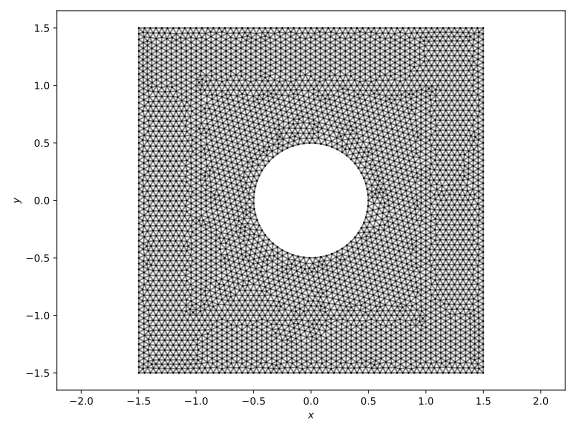

In [9]:
graph.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

## Figure 2: Boundary conditions map

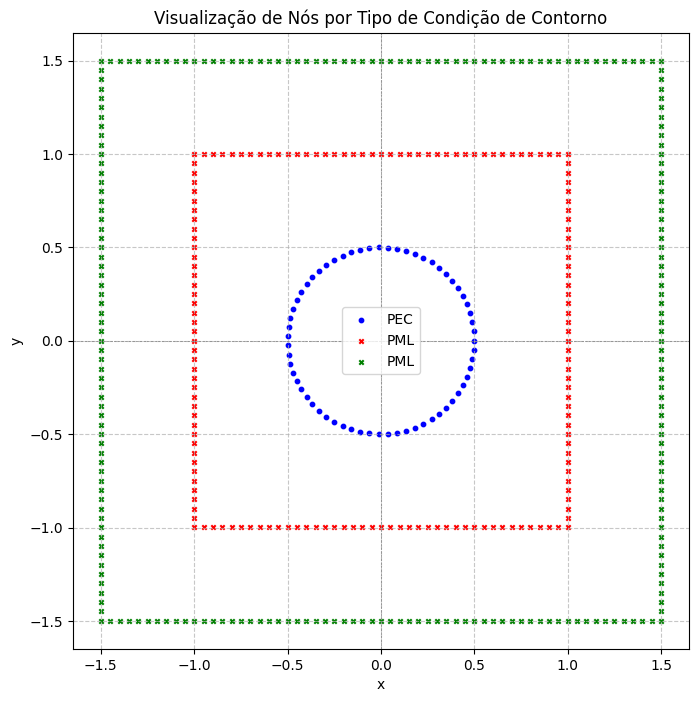

In [10]:
ps.plot_coordinates(mesh_data)

## FEM Solution

In [11]:
Sgr, fgr, Mgr, _, _ = assembly.reduced_global_matrices(FINITE_ELEMENT, mesh_data, bc_pml=True)
print("Reduced global matrix shape:", Sgr.shape)

# Montagem da matriz global
Agr = Sgr - (K0**2) * Mgr

# Solução do problema matricial
ezhr = spsolve(Agr.tocsr(), fgr.toarray())
ezh = assembly.global_potentials_solution(mesh_data, ezhr)

Reduced global matrix shape: (4009, 4009)


## Figure 3: Numerical solution to scattered electric field, $E_z^s$, at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


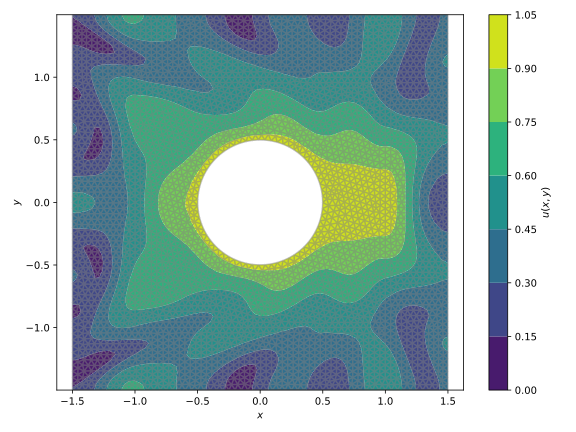

In [12]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, ezh, type='abs')
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle1_EntireDomain.svg"))

# Physical Domain, $\Omega_{fs}$

## Figure 4: Meshed $\Omega_{fs}$ Domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_physical_domain_Triangle1_EntireDomain.svg


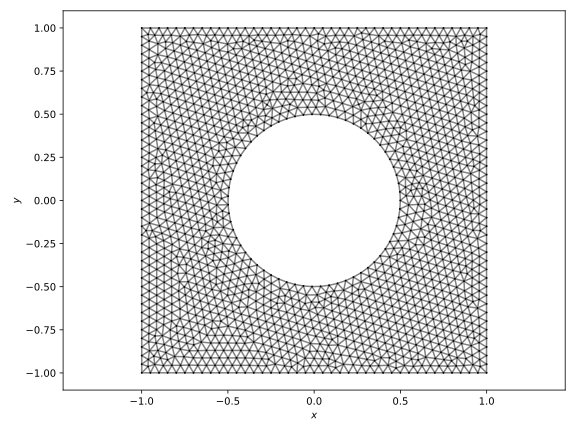

In [13]:
physical_mesh_data = ps.get_physical_mesh_data(mesh_data)
ps.plot_physical_mesh(FINITE_ELEMENT, mesh_data, physical_mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 5: Analytical solution to scattered electric field, $E_z^s$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg


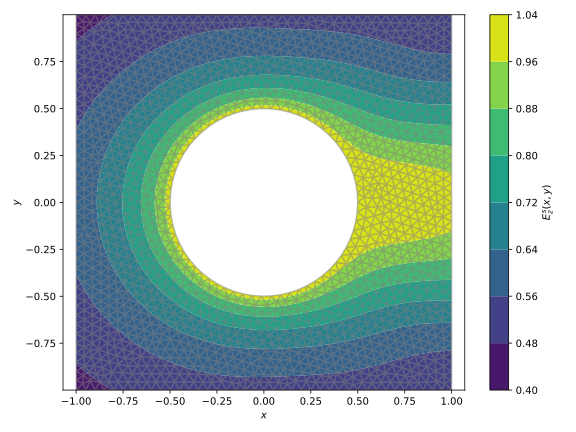

In [14]:
ez = ps.solution_at_physical_domain(FINITE_ELEMENT, OMEGA_KEY, physical_mesh_data, type='abs')
display(SVG(filename="pos_processing/pictures/analytical_solution_at_physical_domain.svg"))

## Figure 6: Numerical solution to scattered electric field, ${Ez}^s_h$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_at_physical_domain_Triangle1_EntireDomain.svg


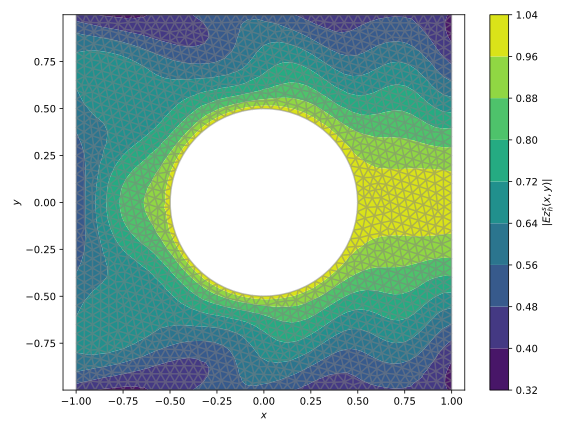

In [15]:
ezh_phy = ps.fem_solution_at_physical_domain(FINITE_ELEMENT, mesh_data, physical_mesh_data, ezh, type='abs')
display(SVG(filename="pos_processing/pictures/fem_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.